# Choix du modèle prédictif

Import des librairies et du filtre des avertissements inutiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

Chargement des dataframes df_idf et df_paris

In [2]:
'''with open(r"dataFrames\df_idf.pkl", "rb") as f:
    my_unpickler = pickle.Unpickler(f)
    df_idf = my_unpickler.load()

df_idf = pd.read_csv(r'dataFrames\df_idf.csv')

with open(r"dataFrames\df_paris.pkl", "rb") as f:
    my_unpickler = pickle.Unpickler(f)
    df_paris = my_unpickler.load()'''

df_idf = pd.read_csv(r'dataFrames/df_idf.csv')
df_paris = pd.read_csv(r'dataFrames/df_paris.csv')

### Choix du modèle sur les données parisienne avec les coordonnées des transactions (latitude et longitude) comme seul paramètre.

Split des données du dataframe df_paris (80% train, 20% test)

In [3]:
X_paris = df_paris[['longitude', 'latitude']].values
y_paris = df_paris['prix_m2'].values
print(X_paris)

X_train_paris, X_test_paris, y_train_paris, y_test_paris = train_test_split(X_paris, y_paris, test_size=0.2, random_state=42)

[[ 2.40375064 48.83624849]
 [ 2.348148   48.86560434]
 [ 2.32468916 48.88330859]
 ...
 [ 2.33382336 48.87932351]
 [ 2.36336334 48.8569176 ]
 [ 2.38413572 48.88687906]]


Déclaration d'une fonction nous permetant de visualiser les données du dataframe avec des contours de décision d'un modèle.

In [4]:
def plot_with_contour(model, X, y):
    # Visualisation des contours de décision
    x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
        
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                        np.arange(y_min, y_max, 0.001))
        
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
        
    plt.contourf(xx, yy, Z, alpha=0.7, cmap='CMRmap')
        
    sc = plt.scatter(X[:, 0], X[:, 1], c=y, vmin=np.percentile(y, 5), vmax=np.percentile(y, 95), 
                        marker='o', s=5, linewidth=1, cmap='CMRmap')
         
    plt.colorbar(sc, label='prix m2', orientation='vertical')

    x = str(model).find('(')
          
    plt.title(f"Contours de décision du modèle {str(model)[:x]}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Création et entrainement de quatre modèles

In [5]:
paris_model_DecisionTreeRegressor = DecisionTreeRegressor(max_depth=4)
paris_model_DecisionTreeRegressor.fit(X_train_paris, y_train_paris)

paris_model_KNeighborsRegressor = KNeighborsRegressor(n_neighbors=50)
paris_model_KNeighborsRegressor.fit(X_train_paris, y_train_paris)

paris_model_LinearRegression = LinearRegression()
paris_model_LinearRegression.fit(X_train_paris, y_train_paris)

paris_model_RandomForestRegressor = RandomForestRegressor(max_depth=100, min_samples_leaf=10)
paris_model_RandomForestRegressor.fit(X_train_paris, y_train_paris)

RandomForestRegressor(max_depth=100, min_samples_leaf=10)

Visualisation des données avec contour de décision pour tous les modèles entrainés juste au-dessus.  
On en profite pour retourner les MSE de train et de test pour chacun des modèles.

La MSE d'entrainement (sur 80% du dataset) du modèle DecisionTreeRegressor est d'environ 2353.84
La MSE de test (sur les 20% restant du dataset) du modèle DecisionTreeRegressor est d'environ 2388.93


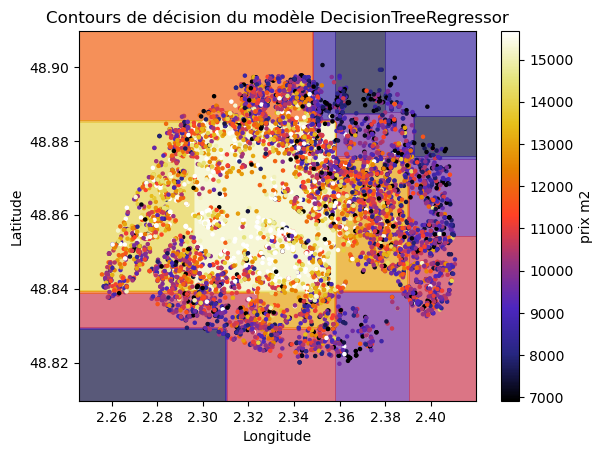

La MSE d'entrainement (sur 80% du dataset) du modèle KNeighborsRegressor est d'environ 2151.73
La MSE de test (sur les 20% restant du dataset) du modèle KNeighborsRegressor est d'environ 2214.47


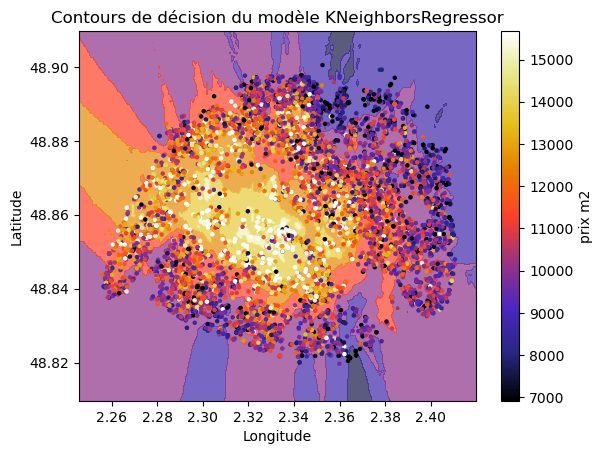

La MSE d'entrainement (sur 80% du dataset) du modèle LinearRegression est d'environ 2556.82
La MSE de test (sur les 20% restant du dataset) du modèle LinearRegression est d'environ 2563.97


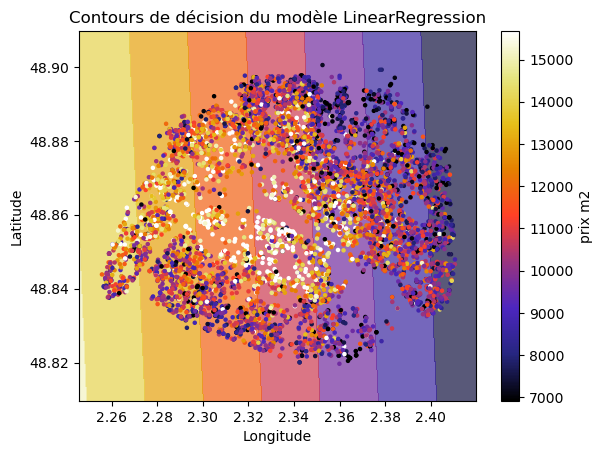

La MSE d'entrainement (sur 80% du dataset) du modèle RandomForestRegressor est d'environ 1919.46
La MSE de test (sur les 20% restant du dataset) du modèle RandomForestRegressor est d'environ 2221.6


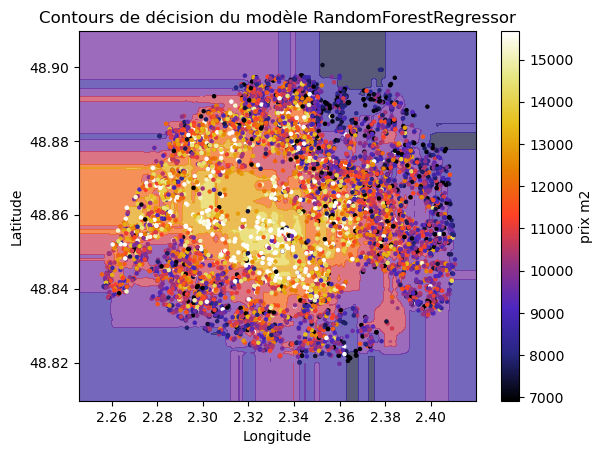

In [6]:
models = [paris_model_DecisionTreeRegressor,paris_model_KNeighborsRegressor, paris_model_LinearRegression, paris_model_RandomForestRegressor]

for model in models :
    x = str(model).find('(')
    print(f"La MSE d'entrainement (sur 80% du dataset) du modèle {str(model)[:x]} est d'environ {round(np.sqrt(mean_squared_error(y_train_paris, model.predict(X_train_paris))),2)}")
    print(f"La MSE de test (sur les 20% restant du dataset) du modèle {str(model)[:x]} est d'environ {round(np.sqrt(mean_squared_error(y_test_paris, model.predict(X_test_paris))),2)}")  
    plot_with_contour(model, X_test_paris, y_test_paris)
    

On applique une grille de recherche (GridSearchCV) à nos modèles sur un ensemble d'hyperparamètres.  
Cela nous permet de trouver la meilleurs option à choisir parmis nos modèles.

In [7]:
params_grid = {
                'LR': {
                    'model': LinearRegression(),
                    'params': {
                        'fit_intercept': [True, False],
                        'positive': [True, False]
                    }
                },
                'KNB': {
                    'model': KNeighborsRegressor(),
                    'params': {
                        'n_neighbors': list(range(20,80))
                    }
                },
                'DTR': {
                    'model': DecisionTreeRegressor(),
                    'params': {
                        'max_depth': [5, 10],
                        'min_samples_leaf': [50, 100]
                    }
                },
                'RFR': {
                    'model': RandomForestRegressor(n_estimators=500),
                    'params': {
                        'max_depth': [4, 8],
                        'min_samples_leaf': [50, 100]
                        #'n_estimators': [500, 1000]
                        # paramètre retiré car demande trop de temps pour être traité
                    }
                }
            }

for model_name, model_config in params_grid.items():
    gs = GridSearchCV(estimator=model_config['model'], 
                      param_grid=model_config['params'],
                      n_jobs=-1)
    gs.fit(X_train_paris, y_train_paris)
    mse = np.sqrt(mean_squared_error(y_test_paris, gs.best_estimator_.predict(X_test_paris)))
    print(f'Le modèle {model_name} avec les params optimaux: {gs.best_params_} donne un MSE de {round(mse,2)}€/m²')

Le modèle LR avec les params optimaux: {'fit_intercept': True, 'positive': False} donne un MSE de 2563.97€/m²
Le modèle KNB avec les params optimaux: {'n_neighbors': 77} donne un MSE de 2213.69€/m²
Le modèle DTR avec les params optimaux: {'max_depth': 10, 'min_samples_leaf': 50} donne un MSE de 2231.02€/m²
Le modèle RFR avec les params optimaux: {'max_depth': 8, 'min_samples_leaf': 50} donne un MSE de 2209.46€/m²


La grille de recherche nous a permis de trouver le meilleur modèle à choisir (celui avec la MSE la plus faible).  
Nous le ré-entrainons avec le ou les hyperparamètres "conseillé.s" par le GridSearch et nous l'enregistrons en .pkl, afin de nous en servir plus tard.

In [8]:
paris_model_RandomForestRegressor = RandomForestRegressor(max_depth=8, min_samples_leaf=50, n_estimators=500)
paris_model_RandomForestRegressor.fit(X_train_paris, y_train_paris)

with open("model/paris_model.pkl", "wb") as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(paris_model_RandomForestRegressor)

### Choix du modèle pour toute l'IDF avec un paramètre supplémentaire :  
### - le taux d'intérêt moyen du mois des transactions

Nous ajoutons le taux d'intérèt moyen mensuel correspondant au mois de chaque transactions de l'IDF.  
Nous mergons ces données à notre dataframe df_idf puis nous pouvons spliter les données du dataframe df_idf (80% train, 20% test).

In [9]:
df_tauxInterets = pd.read_csv(r'dataSources/taux_interet.csv')

df_tauxInterets['monthlyPeriod'] = df_tauxInterets['date'].str[0:7]
df_idf['monthlyPeriod'] = df_idf['date_transaction'].str[0:7]

df_idfFinal = pd.merge(df_idf, df_tauxInterets, on='monthlyPeriod', how='left')

df_idfFinal.columns

X = df_idfFinal[['longitude', 'latitude', 'taux']].values
y = df_idfFinal['prix_m2'].values
print(X)

X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(X, y, test_size=0.2, random_state=42)

[[ 2.40375064 48.83624849  1.07      ]
 [ 2.348148   48.86560434  1.07      ]
 [ 2.32468916 48.88330859  1.07      ]
 ...
 [ 2.21748065 48.99549225  2.12      ]
 [ 2.3147687  48.97772502  2.12      ]
 [ 2.21243488 49.0221078   2.12      ]]


Même chose que pour le modèle précédent : nous créons une grille de recherche (avec les mêmes modèles et les mêmes hyperparamètres que plus haut) qui nous permettra de séléctionner le meilleur modèle.

In [ ]:
for model_name, model_config in params_grid.items():
    gs = GridSearchCV(estimator=model_config['model'], 
                      param_grid=model_config['params'],
                      n_jobs=-1)
    gs.fit(X_train_idf, y_train_idf)
    mse = np.sqrt(mean_squared_error(y_test_idf, gs.best_estimator_.predict(X_test_idf)))
    print(f'Le modèle {model_name} avec les params optimaux: {gs.best_params_} donne un MSE de {round(mse,2)}€/m²')

Le modèle LR avec les params optimaux: {'fit_intercept': True, 'positive': False} donne un MSE de 3656.77€/m²
Le modèle KNB avec les params optimaux: {'n_neighbors': 24} donne un MSE de 1998.84€/m²
Le modèle DTR avec les params optimaux: {'max_depth': 10, 'min_samples_leaf': 50} donne un MSE de 2010.36€/m²


Maintenant que nous avons sélectionner le meilleur modèle, nous l'entrainons (toujours avec les mêmes hyperparamètres que ceux "conseillés" par GridSearch).

In [ ]:
idf_model_KNeighborsRegressor = KNeighborsRegressor(n_neighbors=24)
idf_model_KNeighborsRegressor.fit(X_train_idf, y_train_idf)

x = str(idf_model_KNeighborsRegressor).find('(')
print(f"La MSE d'entrainement (sur 80% du dataset) du modèle {str(idf_model_KNeighborsRegressor)[:x]} est d'environ {round(np.sqrt(mean_squared_error(y_train_idf, idf_model_KNeighborsRegressor.predict(X_train_idf))),2)}")
print(f"La MSE de test (sur les 20% restant du dataset) du modèle {str(idf_model_KNeighborsRegressor)[:x]} est d'environ {round(np.sqrt(mean_squared_error(y_test_idf, idf_model_KNeighborsRegressor.predict(X_test_idf))),2)}")

Enfin, nous l'enregistrons en .pkl pour un usage ultérieur.

In [ ]:
with open("model/idf_model.pkl", "wb") as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(idf_model_KNeighborsRegressor)